In [1]:
import torch

print("Python:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Torch CUDA:", torch.version.cuda)
print("GPU:", torch.cuda.get_device_name(0))


Python: 2.5.1+cu121
CUDA available: True
Torch CUDA: 12.1
GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [5]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [9]:
test_data.data.size()

torch.Size([10000, 28, 28])

In [10]:
train_data.targets.shape

torch.Size([60000])

In [11]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [12]:
from torch.utils.data import DataLoader
loaders = {
    'train': DataLoader(train_data,
                       batch_size=100,
                       shuffle=True,
                       num_workers=1),
    
    'test': DataLoader(test_data,
                       batch_size=100,
                       shuffle=True,
                       num_workers=1)
}

In [13]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x17dffbc8340>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x17dffbca650>}

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        x = x.view(x.size(0), -1)   # safer than (-1, 320)
        x = F.relu(self.fc1(x))

        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return x   # ❗ NO softmax


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()


def train(epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(loaders["train"]):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = model(data)
        loss = loss_fn(output, target)

        loss.backward()
        optimizer.step()

        if batch_idx % 20 == 0:
            print(
                f"Train Epoch {epoch} "
                f"[{batch_idx * len(data)}/{len(loaders['train'].dataset)} "
                f"({100. * batch_idx / len(loaders['train']):.0f}%)]\t"
                f"Loss: {loss.item():.6f}"
            )


def test():
    model.eval()

    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for data, target in loaders["test"]:
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += loss_fn(output, target).item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders["test"].dataset)

    print(
        f"\nTest set: Average loss: {test_loss:.4f}, "
        f"Accuracy: {correct}/{len(loaders['test'].dataset)} "
        f"({100. * correct / len(loaders['test'].dataset):.0f}%)\n"
    )


In [16]:
for epoch in range(1, 11):
    train(epoch)  
    test()          

Train Epoch 1 [0/60000 (0%)]	Loss: 2.310929
Train Epoch 1 [2000/60000 (3%)]	Loss: 2.223731
Train Epoch 1 [4000/60000 (7%)]	Loss: 1.789836
Train Epoch 1 [6000/60000 (10%)]	Loss: 1.406598
Train Epoch 1 [8000/60000 (13%)]	Loss: 1.205204
Train Epoch 1 [10000/60000 (17%)]	Loss: 0.827075
Train Epoch 1 [12000/60000 (20%)]	Loss: 0.770804
Train Epoch 1 [14000/60000 (23%)]	Loss: 0.523421
Train Epoch 1 [16000/60000 (27%)]	Loss: 0.662469
Train Epoch 1 [18000/60000 (30%)]	Loss: 0.587049
Train Epoch 1 [20000/60000 (33%)]	Loss: 0.538305
Train Epoch 1 [22000/60000 (37%)]	Loss: 0.533045
Train Epoch 1 [24000/60000 (40%)]	Loss: 0.446538
Train Epoch 1 [26000/60000 (43%)]	Loss: 0.541070
Train Epoch 1 [28000/60000 (47%)]	Loss: 0.642868
Train Epoch 1 [30000/60000 (50%)]	Loss: 0.409828
Train Epoch 1 [32000/60000 (53%)]	Loss: 0.472105
Train Epoch 1 [34000/60000 (57%)]	Loss: 0.524908
Train Epoch 1 [36000/60000 (60%)]	Loss: 0.403435
Train Epoch 1 [38000/60000 (63%)]	Loss: 0.281746
Train Epoch 1 [40000/60000 (67%

In [18]:
device


device(type='cuda')

prediction: 4


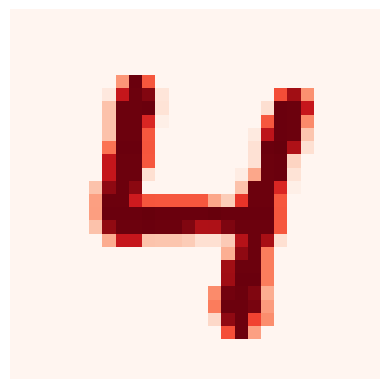

In [24]:
import matplotlib.pyplot as plt

model.train()

data, target = test_data[56]
data = data.unsqueeze(0).to(device)

output = model(data)
prediction = output.argmax(dim=1, keepdim=True).item()
print(f"prediction: {prediction}")

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap="Reds")

plt.axis("off")
plt.show()


In [25]:
model.eval()
data, target = test_data[0]

data = data.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(data)
    pred = output.argmax(1).item()

print("Prediction:", pred)
print("Actual:", target)


Prediction: 7
Actual: 7


In [30]:
import torch
from torchvision import transforms
import PIL.ImageOps
from PIL import Image

# Also make sure your 'device' is defined for the .to(device) part
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
def predict_my_digit(image_path, model):
    # 1. Load the image and convert to Grayscale ('L')
    img = Image.open(image_path).convert('L')
    
    # 2. Invert colors (MNIST is white ink on black background)
    img = PIL.ImageOps.invert(img)
    
    # 3. Resize to exactly 28x28 pixels
    img = img.resize((28, 28))
    
    # 4. Convert to Tensor and Normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0).to(device) # Add batch dimension (1, 1, 28, 28)

    # 5. Predict!
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        prediction = output.argmax(dim=1, keepdim=True)
        
    return prediction.item()

In [63]:
result = predict_my_digit('my_digit1.png', model)
print(f"The model thinks you wrote a: {result}")

The model thinks you wrote a: 4


In [64]:
result = predict_my_digit('my_digit2.png', model)
print(f"The model thinks you wrote a: {result}")

The model thinks you wrote a: 8
